# Building the Bureau of Indian Affairs (BIA) land area representation suitablity layer for GRIDCERF


The following code was used to build the Bureau of Indian Affairs (BIA) land area representation suitability layer for GRIDCERF. GRIDCERF does not provide the source data directly due to some license restrictions related for direct redistribution of the unaltered source data.  However, the following details the provenance associated with each source dataset and how they were processed.


## 1. Setup environment

### 1.1 Download GRIDCERF


Download the GRIDCERF package if you have not yet done so from here: https://doi.org/10.57931/2281697. Please extract GRIDCERF inside the data directory of this repository as the paths in this notebook are set to that expectation.

### 1.2 Import necessary Python packages

In [1]:
import os
import glob
import shutil
import tempfile

import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
import rasterio.mask
from rasterio import features
import shapely.speedups


## 2. Configuration


In [2]:
# get the parent directory path to where this notebook is currently stored
root_dir = os.path.dirname(os.getcwd())

# data directory in repository
data_dir = os.path.join(root_dir, "data")

# GRIDCERF data directory from downloaded archive
gridcerf_dir = os.path.join(data_dir, "gridcerf")

# GRIDCERF reference data directory
reference_dir = os.path.join(gridcerf_dir, "reference")

# GRIDCERF technology specific data directory
output_dir = os.path.join(gridcerf_dir, "technology_specific")

# GRIDCERF source data directory
source_dir = os.path.join(gridcerf_dir, "source", "technology_specific")

# template land mask raster
template_raster = os.path.join(reference_dir, "gridcerf_sitingmask.tif")

# raw BIA LAR data
input_file = os.path.join(source_dir, "bia_land-area-representations", "BIA_National_LAR.shp")


## 3. Generate common suitability rasters

### 3.1 Functions to build suitability


In [3]:
def vector_to_raster(template_raster: str, 
                     gdf: gpd.GeoDataFrame, 
                     value_field: str, 
                     output_raster: str,
                     all_touched: bool = True):
    """Convert a vector layer to a raster in the GRIDCERF format.
    
    :param template_raster:         Full path with file name and extension to the input template 
                                    raster using the GRIDCERF format.
    :type template_raster:          str 
    
    :param gdf:                     Geodataframe for the vector data.
    :type gdf:                      gpd.GeoDataFrame
    
    :param value_field:             Field to use to burn raster value in.
    :type value_field:              str
    
    :param output_raster:           Full path with output name and extension for the output raster.
    :type output_raster:            str
    
    :param all_touched:             If True, all pixels touched by geometries will be burned in. 
                                    If false, only pixels whose center is within the polygon or that 
                                    are selected by Bresenham’s line algorithm will be burned in.
    :type all_touched:              bool
    """
                     
    # open the template raster and extract metadata and land mask
    with rasterio.open(template_raster) as template:

        metadata = template.meta.copy()

        # update raster data type
        metadata.update(dtype=np.int16)

        # extract land mask
        land_mask = template.read(1)
        land_mask = np.where(land_mask == 0, np.nan, 1)

        # write output raster
        with rasterio.open(output_raster, 'w+', **metadata) as out:

            out_arr = out.read(1)

            # build shapes to rasterize from target geometry and field
            shapes = ((geom, value) for geom, value in zip(gdf.geometry, gdf[value_field]))

            # burn features
            burned = features.rasterize(shapes=shapes, 
                                        fill=0, 
                                        out=out_arr, 
                                        transform=out.transform,
                                        all_touched=all_touched)
            
            burned = np.where(burned == 1, 1, 0).astype(np.float64)
            
            # apply land mask
            burned *= land_mask
            
            # make nan excluded
            burned = np.where(np.isnan(burned), 1, burned)

            out.write_band(1, burned.astype(np.int16))


### 3.2 Set standard raster template

In [4]:
# open the template raster and extract metadata and land mask
with rasterio.open(template_raster) as template:

    metadata = template.meta.copy()

    # update raster data type
    metadata.update(dtype=np.float64)

    # extract land mask
    land_mask = template.read(1)
    land_mask = np.where(land_mask == 0, np.nan, 1)

    # get the template CRS
    template_crs = template.crs
        

### 3.3 Process suitability layer

#### gridcerf_bia_land_area_representations_conus.tif

- **Title**:  Bureau of Indian Affairs (BIA) Land Area Representations
- **Description from Source**:  The purpose of the American Indian and Alaska Native Land Area Representation (AIAN-LAR) Geographic Information System (GIS) dataset is to depict the external extent of federal Indian reservations and the external extent of associated land held in “trust” by the United States, “restricted fee” or “mixed ownership” status for federally recognized tribes and individual Indians. This dataset includes other land area types such as Public Domain Allotments, Dependent Indian Communities and Homesteads. This GIS Dataset is prepared strictly for illustrative and reference purposes only and should not be used, and is not intended for legal, survey, engineering or navigation purposes. No warranty is made by the Bureau of Indian Affairs (BIA) for the use of the data for purposes not intended by the BIA. This GIS Dataset may contain errors. There is no impact on the legal status of the land areas depicted herein and no impact on land ownership. No legal inference can or should be made from the information in this GIS Dataset. The GIS Dataset is to be used solely for illustrative, reference and statistical purposes and may be used for government to government Tribal consultation. Reservation boundary data is limited in authority to those areas where there has been settled Congressional definition or final judicial interpretation of the boundary. Absent settled Congressional definition or final judicial interpretation of a reservation boundary, the BIA recommends consultation with the appropriate Tribe and then the BIA to obtain interpretations of the reservation boundary. The land areas and their representations are compilations defined by the official land title records of the Bureau of Indian Affairs (BIA) which include treaties, statutes, Acts of Congress, agreements, executive orders, proclamations, deeds and other land title documents. The trust, restricted, and mixed ownership land area shown here, are suitable only for general spatial reference and do not represent the federal government’s position on the jurisdictional status of Indian country. Ownership and jurisdictional status is subject to change and must be verified with plat books, patents, and deeds in the appropriate federal and state offices. Included in this dataset are the exterior extent of off reservation trust, restricted fee tracts and mixed tracts of land including Public Domain allotments, Dependent Indian Communities, Homesteads and government administered lands and those set aside for schools and dormitories. There are also land areas where there is more than one tribe having an interest in or authority over a tract of land but this information is not specified in the AIAN-LAR dataset. The dataset includes both surface and subsurface tracts of land (tribal and individually held) “off reservation” tracts and not simply off reservation “allotments” as land has in many cases been subsequently acquired in trust. These data are public information and may be used by various organizations, agencies, units of government (i.e., Federal, state, county, and city), and other entities according to the restrictions on appropriate use. It is strongly recommended that these data be acquired directly from the BIA and not indirectly through some other source, which may have altered or integrated the data for another purpose for which they may not have been intended. Integrating land areas into another dataset and attempting to resolve boundary differences between other entities may produce inaccurate results. It is also strongly recommended that careful attention be paid to the content of the metadata file associated with these data. Users are cautioned that digital enlargement of these data to scales greater than those at which they were originally mapped can cause misinterpretation. The BIA AIAN-LAR dataset’s spatial accuracy and attribute information are continuously being updated, improved and is used as the single authoritative land area boundary data for the BIA mission. These data are available through the Bureau of Indian Affairs, Office of Trust Services, Division of Land Titles and Records, Branch of Geospatial Support.
- **Source URL**:  https://data.nativeland.info/gl/dataset/bureau-of-indian-affairs-land-area-representations/resource/f83449c2-bdf7-4edd-aa45-759587f3f48f
- **Date Accessed**:  8/1/23
- **Citation**
> Bureau of Indian Affairs. American Indian and Alaskan Native Land Area Representations (LAR). U.S. Department of the Interior Indian Affairs https://biamaps.doi.gov/bogs/datadownload.html (2019).


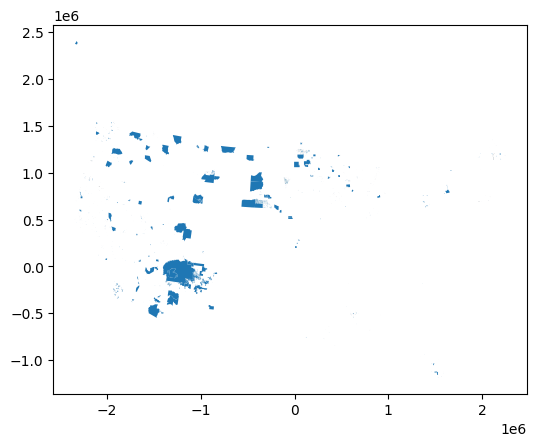

In [5]:
# read in shapefile
gdf = gpd.read_file(input_file)

# reproject to GRIDCERF 
gdf = gdf.to_crs(template_crs)

# assign raster value field
gdf["rval"] = 1

gdf.plot()

# output raster name
output_raster = os.path.join(output_dir, "gridcerf_bia_land_area_representations_conus.tif")

# rasterize 
vector_to_raster(template_raster, 
                 gdf, 
                 value_field="rval", 
                 output_raster=output_raster,
                 all_touched=True)
